In [44]:
!pip3 install plotnine

     |████████████████████████████████| 4.7 MB 35.8 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 108 kB/s  eta 0:00:01
     |████████████████████████████████| 111 kB 69.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [45]:
import io
import os
import json
import zipfile
import urllib
import boto3
from plotnine import *

import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role

from datetime import datetime

# pyspark 환경 셋업
from pyspark.sql import SparkSession

# EDA를 위한 그래프를 그리기 위해 셋업.
%matplotlib inline
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

role = get_execution_role()

In [5]:
MACH_DATA = 'PdM_machines.csv'
MAINT_DATA = 'PdM_maint.csv'
ERROR_DATA = 'PdM_errors.csv'
TELEMETRY_DATA = 'PdM_telemetry.csv'
FAILURE_DATA = 'PdM_failures.csv'

In [9]:
data_folder = 'data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
urllib.request.urlretrieve('https://github.com/KIMCAT33/smartfactory/raw/master/data/EquipData.zip', os.path.join(data_folder, 'EquipData.zip'))

with zipfile.ZipFile(os.path.join(data_folder, 'EquipData.zip'), "r") as zip_ref:
    zip_ref.extractall(data_folder)
    

### 장비 데이터 세트
이 데이터세트는 2015년 동안 100개의 장비에 대해 수집한 데이터를 활용합니다. 
장비 데이터는 각 장비에 대한 정보를 포함하며 여기에는 장비 ID, 모델 타입, 그리고 연식이 있습니다.

In [12]:
basedataurl = "data/EquipData/"

machines = pd.read_csv(basedataurl+MACH_DATA, encoding='utf-8')
print(machines.count())
machines.head(10)

machineID    100
model        100
age          100
dtype: int64


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
5,6,model3,7
6,7,model3,20
7,8,model3,16
8,9,model4,7
9,10,model3,10


아래의 그래프는 특정한 장비의 모델에 따라 장비의 연식을 히스토그램으로 나타내줍니다.

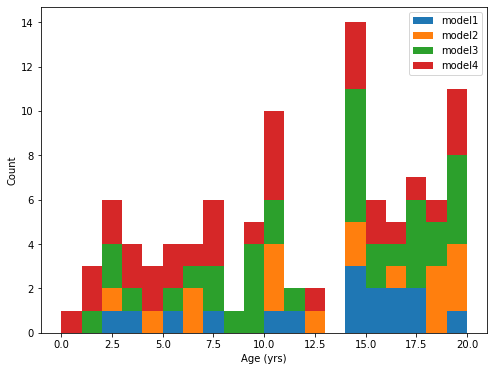

In [15]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

이 그래프는 장비가 사용된 기간을 보여줍니다. 다른 색상으로 표시된 4가지 장비 유형이 있음을 나타내며 4가지 모델 모두 20년 동안 사용되었습니다. 장비의 사용된 수명은 분석의 한 특징이 될 것입니다. 왜냐하면 오래된 장비에는 오랫동안 사용되지 않은 장비와 다른 오류 및 결함 집합이 있을 수 있기 때문입니다. 다음으로 장비 데이터를 Spark 데이터 프레임으로 변환하고 데이터 유형이 올바르게 변환되었는지 확인합니다.

In [21]:
# 지금까지 Pandas 데이터 프레임을 사용하여 데이터를 읽었습니다. Spark에서 사용할 수 있는 형식이 되도록 pyspark로 변환합니다.
mach_spark = spark.createDataFrame(machines, 
                                   verifySchema=False)

# Pandas 데이터 프레임이 필요없기 때문에, 메모리를 반환합니다.
del machines

# 데이터 타입 변환이 되었는지 확인합니다.
mach_spark.printSchema()

root
 |-- machineID: long (nullable = true)
 |-- model: string (nullable = true)
 |-- age: long (nullable = true)



### 에러 데이터 세트
에러 로그는 장비가 계속 작동하는 동안 발생한 중단되지 않는 에러도 포함됩니다. 이러한 에러는 장애로 간주되지 않지만 향후 결함 이벤트를 예측할 수 있습니다. 데이터는 시간당 수집되므로 에러가 발견된 시점은 가장 가까운 시간으로 반올림됩니다.

In [27]:
errors = pd.read_csv(basedataurl+ERROR_DATA, encoding='utf-8')
print(errors.count())
errors.head(10)

datetime     3919
machineID    3919
errorID      3919
dtype: int64


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
5,2015-01-25 15:00:00,1,error4
6,2015-01-27 04:00:00,1,error1
7,2015-03-03 22:00:00,1,error2
8,2015-03-05 06:00:00,1,error1
9,2015-03-20 18:00:00,1,error1


아래의 그래프는 로그 파일에 기록된 에러의 분포를 보여줍니다.

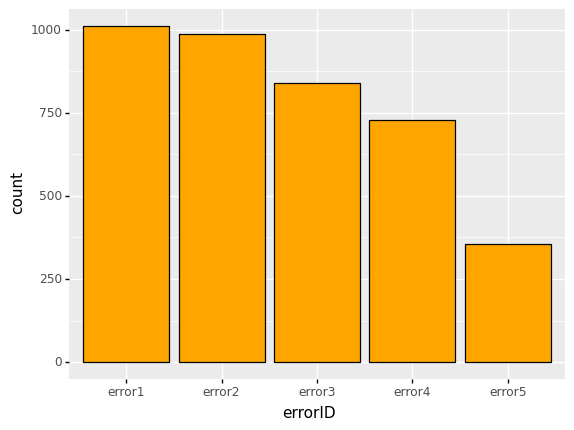

<ggplot: (-9223363268450034502)>

In [48]:
(ggplot(aes(x="errorID"), errors) + geom_bar(fill="orange", color="black"))

에러 데이터는 각 장비에서 발생한 에러 코드의 시계열 데이터로 구성되어 있습니다. 그래프는 1년 동안 5가지 에러 타입이 각각 발생한 횟수를 보여줍니다. 다음으로 에러 데이터를 Spark 데이터 프레임으로 변환하고 데이터 유형이 올바르게 변환되었는지 확인합니다.

In [49]:
# 지금까지 Pandas 데이터 프레임을 사용하여 데이터를 읽었습니다. Spark에서 사용할 수 있는 형식이 되도록 pyspark로 변환합니다.
error_spark = spark.createDataFrame(errors, 
                               verifySchema=False)

# Pandas 데이터 프레임이 필요없기 때문에, 메모리를 반환합니다.
del errors

# 데이터 타입 변환이 되었는지 확인합니다.
error_spark.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- machineID: long (nullable = true)
 |-- errorID: string (nullable = true)



### 점검 데이터 세트
점검 데이터에는 정기 점검 데이터와 예상치 못한 점검에 대한 데이터가 모두 포함됩니다. 예상치 못한 점검은 장비의 고장이나 기타 성능 저하로 인해 발생할 수 있습니다. 점검 데이터에는 부품 교체를 위한 오류 레코드가 포함되어 있습니다. 점검 같은 경우에는 부품에 대한 수명을 추론하는데 사용될 수도 있기 때문에 나머지 데이터가 수집된 2015년 1년간의 데이터뿐 아니라 2014년을 포함하여 총 2년에 걸쳐 수집되었습니다. 

In [52]:
maint = pd.read_csv(basedataurl+MAINT_DATA, encoding='utf-8')
print(maint.count())
maint.head(20)

datetime     3286
machineID    3286
comp         3286
dtype: int64


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4
5,2015-01-05 06:00:00,1,comp1
6,2015-01-20 06:00:00,1,comp3
7,2015-01-20 06:00:00,1,comp1
8,2015-02-04 06:00:00,1,comp4
9,2015-02-04 06:00:00,1,comp3


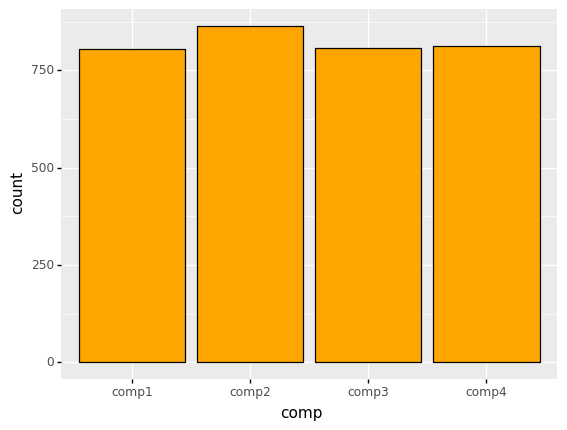

<ggplot: (-9223363268450013766)>

In [53]:
(ggplot(aes(x="comp"), maint) + geom_bar(fill="orange", color="black"))

이 그래프는 4가지 각 부품에 대해 점검 결과로 교체된 횟수를 나타냅니다. 그래프를 보면 4가지 부품이 비슷한 속도로 교체된 것을 확인할 수 있습니다. 
각 부품이 얼마나 오래 지속되었는지 계산하거나 각 장비 내에서 부품의 교체까지의 시간을 추적하는 등 이를 통해 분석하는 여러가지 방법이 있을 수 있습니다.
다음으로 점검 데이터를 Spark 데이터 프레임으로 변환하고 데이터 유형이 올바르게 변환되었는지 확인합니다.

In [54]:
# 지금까지 Pandas 데이터 프레임을 사용하여 데이터를 읽었습니다. Spark에서 사용할 수 있는 형식이 되도록 pyspark로 변환합니다.
maint_spark = spark.createDataFrame(maint, 
                              verifySchema=False)

# Pandas 데이터 프레임이 필요없기 때문에, 메모리를 반환합니다.
del maint

# 데이터 타입 변환이 되었는지 확인합니다.
maint_spark.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- machineID: long (nullable = true)
 |-- comp: string (nullable = true)



### 시계열 데이터 세트
시계열 데이터는 각 장비에서 실시간으로 수집된 전압, 회전, 압력 및 진동 센서의 측정 값으로 구성됩니다. 데이터는 1시간 동안 평균을 낸 값으로 저장이 됩니다. 

In [55]:
telemetry = pd.read_csv(basedataurl+TELEMETRY_DATA, encoding='utf-8')
print(telemetry.count())
telemetry.head(10)

datetime     876100
machineID    876100
volt         876100
rotate       876100
pressure     876100
vibration    876100
dtype: int64


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
5,2015-01-01 11:00:00,1,172.504839,430.323362,95.927042,35.655017
6,2015-01-01 12:00:00,1,156.556031,499.071623,111.755684,42.753920
7,2015-01-01 13:00:00,1,172.522781,409.624717,101.001083,35.482009
8,2015-01-01 14:00:00,1,175.324524,398.648781,110.624361,45.482287
9,2015-01-01 15:00:00,1,169.218423,460.850670,104.848230,39.901735


In [57]:
# 스키마를 확인하여, datetime을 옳바른 타입으로 변환합니다.
# datetime이 string 타입으로 들어오게 됩니다.
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

이 그래프는 870만 데이터 포인트를 표시하는 대신 단일 장비에 대한 1개월 측정치를 표시합니다. 이것은 센서 데이터 수집의 1년 동안 모든 장비에 대해 반복될 수 있는 그래프를 나타냅니다.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


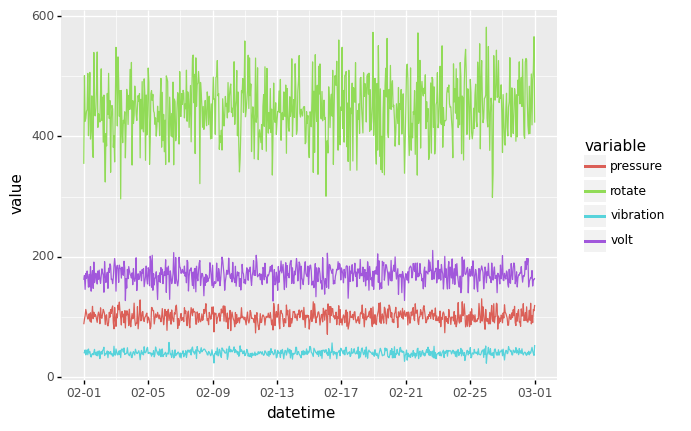

<ggplot: (-9223363268451827463)>

In [75]:
plt_data = telemetry.loc[telemetry['machineID'] == 1]

plt_data['datetime'] = pd.to_datetime(plt_data['datetime'], format="%Y-%m-%d %H:%M:%S")
plot_df = plt_data.loc[(plt_data['datetime'] >= pd.to_datetime('2015-02-01')) &
                       (plt_data['datetime'] <= pd.to_datetime('2015-03-01'))]

plt_data = pd.melt(plot_df, id_vars=['datetime', 'machineID'])

(ggplot(aes(x="datetime", y="value", color = "variable", group="variable"), plt_data)+\
 geom_line() +\
 scale_x_date(date_labels='%m-%d')) 






그래프는 한 장비에 대한 1달간 측정된 센서 데이터를 보여줍니다. 
다음으로 시계열 데이터를 Spark 데이터 프레임으로 변환하고 데이터 유형이 올바르게 변환되었는지 확인합니다.

In [76]:
# 지금까지 Pandas 데이터 프레임을 사용하여 데이터를 읽었습니다. Spark에서 사용할 수 있는 형식이 되도록 pyspark로 변환합니다.
telemetry_spark = spark.createDataFrame(telemetry, verifySchema=False)

# Pandas 데이터 프레임이 필요없기 때문에, 메모리를 반환합니다.
del telemetry
del plt_data
del plot_df

# 데이터 타입 변환이 되었는지 확인합니다.
telemetry_spark.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- machineID: long (nullable = true)
 |-- volt: double (nullable = true)
 |-- rotate: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- vibration: double (nullable = true)



### 결함 데이터 세트
결함은 점검 데이터의 부품 교체에 해당하게 됩니다. 각 레코드는 장비 ID, 부품 타입, 그리고 교체 시간을 나타냅니다. 이 데이터는 예측하려는 모델의 레이블을 만드는데 사용될 수 있습니다.

In [77]:
failures = pd.read_csv(basedataurl+FAILURE_DATA, encoding='utf-8')
print(failures.count())
failures.head(10)

datetime     761
machineID    761
failure      761
dtype: int64


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
5,2015-10-17 06:00:00,1,comp2
6,2015-12-16 06:00:00,1,comp4
7,2015-03-19 06:00:00,2,comp1
8,2015-03-19 06:00:00,2,comp2
9,2015-04-18 06:00:00,2,comp2


다음 그래프는 결함 데이터에서 얻은 결함의 분포를 나타내줍니다.

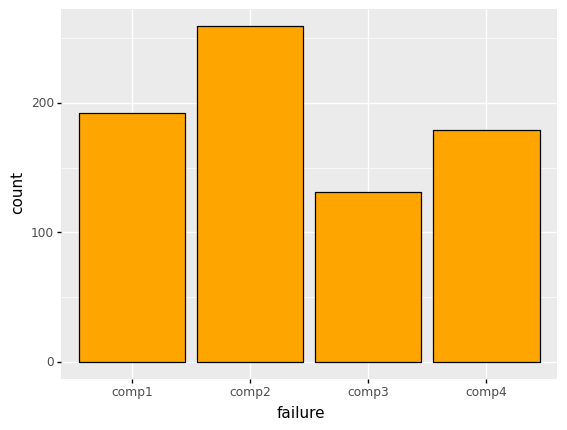

<ggplot: (8768404748436)>

In [79]:
(ggplot(aes(x="failure"), failures) + geom_bar(fill="orange", color="black"))

In [80]:
# 지금까지 Pandas 데이터 프레임을 사용하여 데이터를 읽었습니다. Spark에서 사용할 수 있는 형식이 되도록 pyspark로 변환합니다.
failures_spark = spark.createDataFrame(failures, 
                                       verifySchema=False)

# 데이터 타입 변환이 되었는지 확인합니다.
failures_spark.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- machineID: long (nullable = true)
 |-- failure: string (nullable = true)



### 원본 데이터 S3 저장
남은 노트북 시나리오에서 사용하기 위해 S3 storage에 데이터를 저장합니다.

In [81]:
bucket = 'jdkimexample'
prefix = 'data'

s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

# 원본 데이터를 S3에 업로드합니다.
for subdir, dirs, files in os.walk(basedataurl):
    for file in files:
        full_path = os.path.join(subdir, file)
        s3_path = os.path.join("", full_path)
        s3_bucket_resource.Object(s3_path).upload_file(full_path)

### 결론
필요한 데이터 파일을 csv 형식으로 다운로드해보았습니다. 그리고 데이터를 Pandas 데이터 프레임으로 변환하여 각 데이터 파일에 무엇이 있는지 이해하는데 도움이 되는 몇가지 그래프를 생성할 수 있었습니다. 그런 다음 추가 작업을 위해 데이터를 S3에 저장하였습니다.